In [1]:
#!pip install pandas
#!pip install numpy
import pandas as pd
import numpy as np
import os

In [2]:
os.getcwd()
orders = pd.read_csv("data/olist_orders_dataset.csv")
payments =  pd.read_csv("data/olist_order_payments_dataset.csv")

In [3]:
# Checking for duplicates
orders["order_id"].is_unique

True

In [4]:
payments["order_id"].is_unique

False

In [5]:
# Getting payments from each order
payments.dtypes
payments = payments.groupby(["order_id"])['payment_value'].agg('sum')
payments = pd.DataFrame({'order_id':payments.index, 'payment_value':payments.values})

In [6]:
payments["order_id"].is_unique

True

In [7]:
# Joining to get dates
df = pd.merge(orders,payments)
df = df[["order_id", "order_purchase_timestamp", "payment_value"]]
df.dtypes

order_id                     object
order_purchase_timestamp     object
payment_value               float64
dtype: object

In [8]:
# Converting to date
df[["order_purchase_timestamp"]] = df[["order_purchase_timestamp"]].apply(pd.to_datetime)
df["order_purchase_timestamp"] = df["order_purchase_timestamp"].dt.date

In [9]:
# Getting values for each day
df = df.groupby(["order_purchase_timestamp"])['payment_value'].agg('sum')
df = pd.DataFrame({'date':df.index, 'value':df.values})

In [10]:
df

,date,value
0,2016-09-04,136.23
1,2016-09-05,75.06
2,2016-09-13,40.95
3,2016-10-02,109.34
4,2016-10-03,595.14
...,...,...
628,2018-09-29,137.03
629,2018-10-01,80.38
630,2018-10-03,197.55
631,2018-10-16,222.03


In [11]:
# Missing values for each day considered as 0 
df_dates = pd.DataFrame()
df_dates["date"] = pd.date_range("2016-09-04","2018-10-17")
df_dates["date"] = df_dates["date"].dt.date
df = pd.merge(df,df_dates,how="right",on="date")
df = df.fillna(1)

In [12]:
df = df.loc[200:700]

In [13]:
df

,date,value
200,2017-03-23,22913.37
201,2017-03-24,13386.91
202,2017-03-25,11251.74
203,2017-03-26,7642.02
204,2017-03-27,20549.29
...,...,...
696,2018-08-01,48850.81
697,2018-08-02,45932.70
698,2018-08-03,49517.59
699,2018-08-04,41239.97


In [14]:
#!pip install statsmodels
#!pip install matplotlib
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import figure
import matplotlib.pyplot as plt

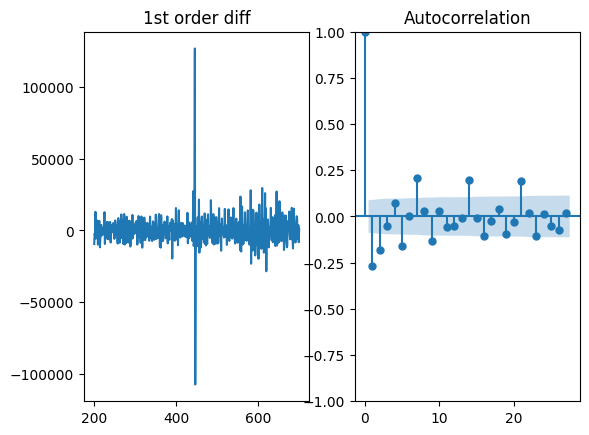

In [15]:
#plot_acf(df["value"])
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order diff')
ax1.plot(df["value"].diff())

ax2 = f.add_subplot(122)
plot_acf(df["value"].diff().dropna(),ax=ax2)
plt.show()

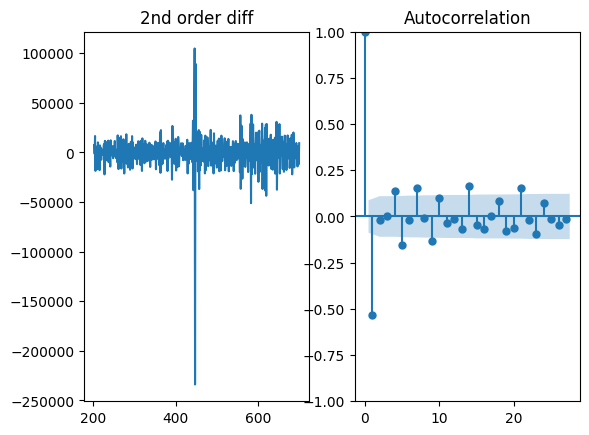

In [16]:
#plot_acf(df["value"])
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd order diff')
ax1.plot(df["value"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df["value"].diff().diff().dropna(),ax=ax2)
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
result = adfuller(df["value"])
print('p-value: ',result[1])
result = adfuller(df["value"].diff().dropna())
print('p-value: ',result[1])

p-value:  0.07949753007322585
p-value:  4.544842864731077e-15


In [19]:
from statsmodels.tsa.arima.model import ARIMA

In [20]:
arima_model = ARIMA(df["value"], order=(1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  501
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5286.061
Date:                Thu, 15 Dec 2022   AIC                          10580.122
Time:                        15:38:27   BIC                          10596.980
Sample:                             0   HQIC                         10586.737
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1406      0.187      0.753      0.451      -0.225       0.506
ma.L1         -0.6397      0.189     -3.387      0.001      -1.010      -0.270
ma.L2         -0.1790      0.158     -1.136      0.2

/opt/homebrew/Caskroom/miniconda/base/envs/ecommerce-data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/ecommerce-data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/ecommerce-data/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


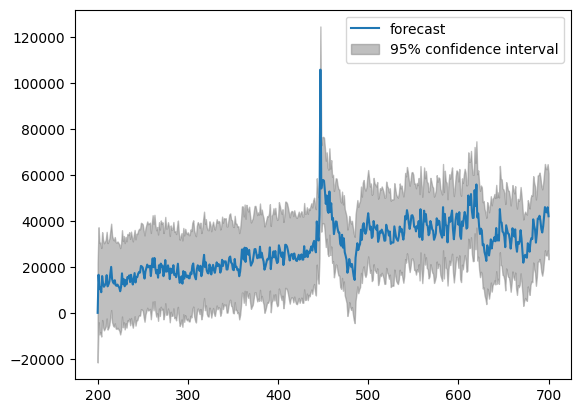

In [21]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model,dynamic=False)
plt.show()

In [ ]:
arima_model = ARIMA(df["value"][:400], order=(0,1,0),seasonal_order=(1,1,1,365.25))
model = arima_model.fit()
print(model.summary())

In [ ]:
#df["date"][:600]

In [ ]:
y_pred = pd.Series(model.forecast(100).to_list(), index = df["date"][400:500])

In [ ]:
y_true = pd.Series(df["value"][400:500].to_list(), index = df["date"][400:500])

In [ ]:
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.mean((y_pred - y_true)**2)**.5

In [ ]:
print(mae)
print(rmse)